# Political Survey Clustering Analysis

#### **Goal:** Take survey data and perform basic statistics and clustering analyses to observe differences between self-identified political groups.
**Date:** October 2023<br>
**Notebook Author(s)**: Ike Silver, Rahim Hashim<br>
**Data Owner(s)**: Ike Silver

## Import / Install Packages
Run the below line to mount Google Drive, where this notebook and the underlying `.xlsx` dataset should be.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
# set max pandas columns to display
pd.set_option('display.max_columns', None)
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

***
## Convert Excel to DataFrame
It will be easiest to observe/analyze the dataset once it's in a pandas DataFrame format. Update the `EXCEL_PATH` variable on the right by finding where the dataset is saved in your Google Drive. You can do so by clicking on the folder icon on the left panel, going to `drive`, navigating to the file, and copy-pasting it in the field to the right.

In [3]:
# convert xlsx to pandas dataframe
def xlsx_to_df(path):
    df = pd.read_excel(path)
    # create a new column which is the length of responses
    df['response_length'] = df['response'].str.len()
    return df

EXCEL_PATH = "/content/drive/MyDrive/Other/Friends/Ike/CLEANFORRAHIM.xlsx" # @param {type:"string"}
df = xlsx_to_df(EXCEL_PATH)
# .head(N) gives the first N rows
df.head(10)

,consent,numcheck,politics,response,outgroup,ingroup,comfort,difficult,upset,strength,engagement_1,engagement_2,engagement_3,Sex,Sex_3_TEXT,Age,PROLIFIC_PID,condition,response_length
0,1,one,-1,"Abortion is a heavy topic, where most liberals...",0.0,100.0,3.0,1.0,4.0,5.0,5.0,4.0,1.0,2.0,NaN,22.0,63d03677605fe885f6006cc2,control,265
1,1,One,-1,Liberals usually believe that gun violence can...,0.0,100.0,1.0,1.0,1.0,7.0,6.0,1.0,1.0,1.0,NaN,55.0,5df961cb53e8466f17606ae1,control,150
2,1,one,-1,Banning books\nLiberals are against it\nConser...,40.0,60.0,4.0,1.0,4.0,3.0,7.0,7.0,7.0,2.0,NaN,51.0,5dddd2a111d494d5526af144,control,77
3,1,one,-1,"Abortion - liberals tend to be prochoice, wher...",50.0,50.0,4.0,2.0,4.0,3.0,2.0,2.0,1.0,2.0,NaN,53.0,5f1f08e1443fd9089b8ab257,control,104
4,1,one,-1,most liberals want to spend more on social equ...,50.0,50.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,2.0,NaN,60.0,63192b009a902051e89fabf1,control,116
5,1,one,-1,Both sides tend to fight over the issues and m...,50.0,50.0,6.0,5.0,4.0,4.0,1.0,1.0,1.0,2.0,NaN,21.0,5dc61266dbf82047e9a63610,control,66
6,1,one,-1,Liberals and conservatives tend to debate on a...,0.0,100.0,4.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,NaN,25.0,5a4a865e58be2b000198586d,control,137
7,1,one,-1,the debt that the USA is in currently they are...,50.0,50.0,4.0,3.0,4.0,7.0,6.0,5.0,2.0,2.0,NaN,59.0,5dd9389d23f9f18b90cb69ce,control,288
8,1,one,-1,Abortion. Liberals usually believe that a woma...,20.0,80.0,1.0,1.0,1.0,5.0,7.0,2.0,1.0,2.0,NaN,38.0,610ec7904b2882f7256934f9,control,170
9,1,one,-1,"On the issue of immigration, liberals tend to ...",0.0,100.0,1.0,1.0,2.0,2.0,4.0,5.0,5.0,1.0,NaN,26.0,627924633c3510cb19625fff,control,227


Delete any rows that have missing datasets.

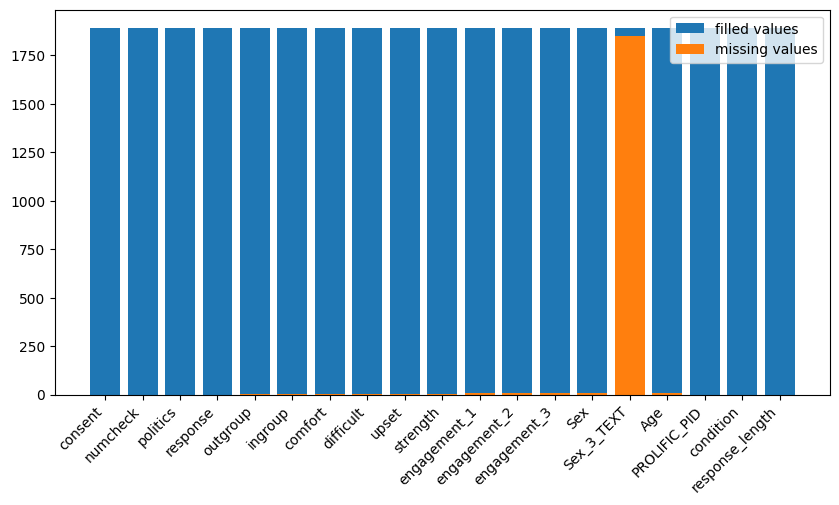

In [4]:
# for each column print the number of missing values
vals_by_column = []
vals_missing_by_column = []
for col in df.columns:
    vals_by_column.append(len(df[col]))
    vals_missing_by_column.append(df[col].isnull().sum())

f, ax = plt.subplots(1,1, figsize=(10,5))
plt.bar(range(len(df.columns)), vals_by_column, label='filled values')
plt.bar(range(len(df.columns)), vals_missing_by_column, label='missing values')
plt.xticks(range(len(df.columns)), df.columns, rotation=45, ha='right')
plt.legend()
plt.show()

It's clear from the above that the `Sex_3_TEXT` column is missing a majority of datasets, so we'll remove that column, and then clear rows that have any other missing data.

In [5]:
del df['Sex_3_TEXT']
df.dropna(inplace=True)

***
## Basic Inter-Group Statistics

To perform statistical testing on differences between groups, select the column you'd like on the drop down on the right that you'd like to group data based on for the rest of the analyses.

In [6]:
# to add more columns, use the format "<column>" and add to the list in green below
column_of_interest = "condition" # @param ["politics", "ingroup", "condition", "Sex"]
df.groupby(column_of_interest).describe()

consent                                    politics            \
            count mean  std  min  25%  50%  75%  max    count      mean   
condition                                                                 
ID          632.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0    632.0 -0.411392   
OC          625.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0    625.0 -0.539200   
control     627.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0    627.0 -0.511962   

                                             outgroup                        \
                std  min  25%  50%  75%  max    count       mean        std   
condition                                                                     
ID         0.912180 -1.0 -1.0 -1.0  1.0  1.0    632.0  31.893987  22.257743   
OC         0.842852 -1.0 -1.0 -1.0 -1.0  1.0    625.0  30.544000  22.194545   
control    0.859694 -1.0 -1.0 -1.0 -1.0  1.0    627.0  24.446571  22.855811   

                                       ingroup                             \
           min  25%   50%   75%    max   count       mean        std  min   
condition                                                                   
ID         0.0  5.0  45.0  50.0  100.0   632.0  68.106013  22.257743  0.0   
OC         0.0  0.0  45.0  50.0  100.0   625.0  69.456000  22.194545  0.0   
control    0.0  0.0  22.0  50.0  100.0   627.0  75.553429  22.855811  0.0   

                                    comfort                                \
            25%   50%    75%    max   count      mean       std  min  25%   
condition                                                                   
ID         50.0  55.0   95.0  100.0   632.0  2.789557  1.669628  1.0  1.0   
OC         50.0  55.0  100.0  100.0   625.0  3.113600  1.768190  1.0  1.0   
control    50.0  78.0  100.0  100.0   627.0  2.743222  1.617426  1.0  1.0   

                         difficult                                          \
           50%  75%  max     count      mean       std  min  25%  50%  75%   
condition                                                                    
ID         3.0  4.0  7.0     632.0  2.837025  1.859662  1.0  1.0  2.0  4.0   
OC         3.0  4.0  7.0     625.0  3.436800  2.155700  1.0  1.0  3.0  5.0   
control    2.0  4.0  7.0     627.0  2.197767  1.456218  1.0  1.0  2.0  3.0   

                upset                                              strength  \
           max  count      mean       std  min  25%  50%  75%  max    count   
condition                                                                     
ID         7.0  632.0  3.417722  1.492571  1.0  2.0  4.0  4.0  7.0    632.0   
OC         7.0  625.0  3.584000  1.612173  1.0  2.0  4.0  4.0  7.0    625.0   
control    7.0  627.0  3.534290  1.494405  1.0  2.0  4.0  4.0  7.0    627.0   

                                                       engagement_1            \
               mean       std  min  25%  50%  75%  max        count      mean   
condition                                                                       
ID         4.205696  1.820494  1.0  3.0  4.0  6.0  7.0        632.0  3.916139   
OC         4.460800  1.837680  1.0  3.0  5.0  6.0  7.0        625.0  4.118400   
control    4.591707  1.808516  1.0  3.0  5.0  6.0  7.0        627.0  4.110048   

                                             engagement_2                      \
                std  min  25%  50%  75%  max        count      mean       std   
condition                                                                       
ID         2.218120  1.0  2.0  4.0  6.0  7.0        632.0  3.318038  1.961222   
OC         2.187244  1.0  2.0  4.0  6.0  7.0        625.0  3.428800  1.974631   
control    2.186733  1.0  2.0  4.0  6.0  7.0        627.0  3.465710  1.940823   

                                   engagement_3                                \
           min  25%  50%  75%  max        count      mean       std  min  25%   
condition                                                                     

Perform basic statistical tests to observe any group differences on each of the quantitative fields.

outgroup
  Mean: control: 24.45
  Mean: ID: 31.89
  Mean: OC: 30.54
  control vs ID: ks_stat: 0.16, p_val: 2.71E-07
  control vs OC: ks_stat: 0.13, p_val: 2.22E-05
  ID vs OC: ks_stat: 0.04, p_val: 7.02E-01
ingroup
  Mean: control: 75.55
  Mean: ID: 68.11
  Mean: OC: 69.46
  control vs ID: ks_stat: 0.16, p_val: 2.71E-07
  control vs OC: ks_stat: 0.13, p_val: 2.22E-05
  ID vs OC: ks_stat: 0.04, p_val: 7.02E-01
comfort
  Mean: control: 2.74
  Mean: ID: 2.79
  Mean: OC: 3.11
  control vs ID: ks_stat: 0.03, p_val: 9.44E-01
  control vs OC: ks_stat: 0.09, p_val: 8.28E-03
  ID vs OC: ks_stat: 0.08, p_val: 3.00E-02
difficult
  Mean: control: 2.2
  Mean: ID: 2.84
  Mean: OC: 3.44
  control vs ID: ks_stat: 0.15, p_val: 1.80E-06
  control vs OC: ks_stat: 0.25, p_val: 3.83E-18
  ID vs OC: ks_stat: 0.12, p_val: 1.12E-04
upset
  Mean: control: 3.53
  Mean: ID: 3.42
  Mean: OC: 3.58
  control vs ID: ks_stat: 0.03, p_val: 8.50E-01
  control vs OC: ks_stat: 0.03, p_val: 8.89E-01
  ID vs OC: ks_stat: 0

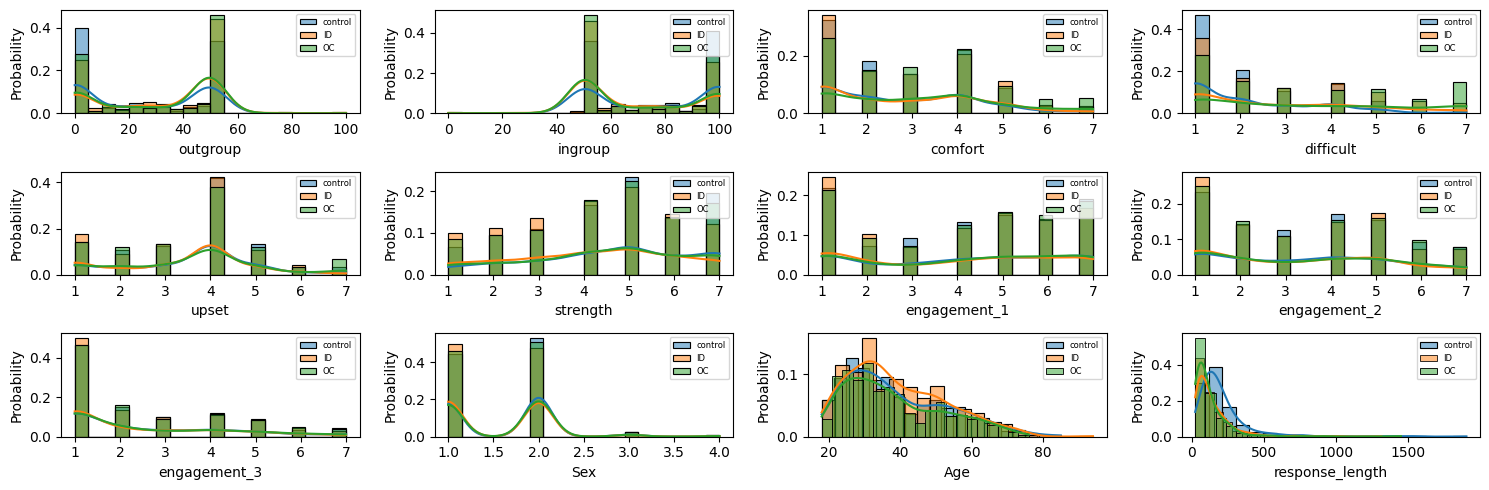

In [7]:
import scipy.stats as stats
from decimal import Decimal
from itertools import combinations

def ks_test_group(group_combinations, values_combinations):
    for g_index, group_combination in enumerate(group_combinations):
      values_pairs = values_combinations[g_index]
      ks_stat, p_val = stats.ks_2samp(values_pairs[0], values_pairs[1])
      group_1, group_2 = group_combination[0], group_combination[1]
      ks_string = round(ks_stat, 2)
      p_val_string = '%.2E' % Decimal(p_val)
      print(f'  {group_1} vs {group_2}: ks_stat: {ks_string}, p_val: {p_val_string}')


# create a grid of histograms for each quantitative variable
def plot_hist(df, cols, grid_cols=4, bins=20):
  num_cols = len(cols)
  # grid of 5 x 2 plots
  fig, ax = plt.subplots(int(np.ceil(num_cols/grid_cols)), grid_cols, figsize=(15, 5))
  # flatten the axis
  ax = ax.flatten()
  # iterate through the columns
  for col in cols:
    print(f'{col}')
    # for statistical testing
    mean_list = []
    values_list = []
    for group in df[column_of_interest].unique():
      data_group = df[df[column_of_interest] == group][col]
      data_group_clean = data_group[~np.isnan(data_group)]
      # plot the histogram
      sns.histplot(data_group_clean, bins=bins, ax=ax[cols.index(col)], label=group, kde=True, stat='probability')
      values_list.append(data_group_clean)
      print(f'  Mean: {group}: {round(data_group_clean.mean(), 2)}')
    # make very small legend in top right of plots
    ax[cols.index(col)].legend(loc='upper right', prop={'size': 6})
    # test for statistical significance
    group_combinations = list(combinations(df[column_of_interest].unique(), 2))
    values_combinations = list(combinations(values_list, 2))
    ks_test_group(group_combinations, values_combinations)
  # set the layout
  plt.tight_layout()

quant_columns = ['outgroup', 'ingroup',	'comfort',	'difficult',	'upset',
	               'strength',	'engagement_1',	'engagement_2', 'engagement_3', 'Sex',
                 'Age', 'response_length']
if column_of_interest == 'politics':
  group_labels = {'-1': 'liberal', '1': 'conservative'}
plot_hist(df, quant_columns)

***
## BERTopic Clustering
The first clustering exercise we'll be performing is via BERTopic (documentation [link](https://github.com/MaartenGr/BERTopic)).

In [8]:
%%capture
!pip install bertopic

## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead.

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model.


In [9]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(df['response'].tolist())

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

2023-10-25 19:10:17,486 - BERTopic - Transformed documents to Embeddings
2023-10-25 19:10:33,628 - BERTopic - Reduced dimensionality
2023-10-25 19:10:33,969 - BERTopic - Clustered reduced embeddings


## Extracting Topics
After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. -1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated.

In [10]:
freq = topic_model.get_topic_info()
num_topics = len(freq['Topic'].unique())
print(f'Number of topics: {num_topics}')
freq.head(10)


Number of topics: 30


,Topic,Count,Name,Representation,Representative_Docs
0,-1,360,-1_the_with_and_of,"[the, with, and, of, to, that, in, on, agree, ...",[I used to think I was a conservative person b...
1,0,340,0_abortion_liberals_conservatives_to,"[abortion, liberals, conservatives, to, believ...",[Liberals and conservatives tend to debate on ...
2,1,273,1_gun_control_guns_to,"[gun, control, guns, to, liberals, and, the, c...",[Liberals believe in gun control. Conservative...
3,2,89,2_immigration_immigrants_illegal_borders,"[immigration, immigrants, illegal, borders, we...",[Democrats are for open borders and illegal im...
4,3,82,3_abortion_should_be_or,"[abortion, should, be, or, it, an, have, right...",[While I agree women should have the right to ...
5,4,76,4_with_agree_any_conservatives,"[with, agree, any, conservatives, conservative...",[I don't have any area of agreement with conse...
6,5,52,5_climate_change_is_real,"[climate, change, is, real, and, believe, that...",[One issue that liberals and conservatives dis...
7,6,42,6_taxes_tax_rich_lower,"[taxes, tax, rich, lower, would, taxing, pay, ...","[the government should lower taxes, I agree wi..."
8,7,41,7_covid_vaccine_vaccines_19,"[covid, vaccine, vaccines, 19, masks, covid19,...",[I tend to agree with conservatives on the COV...
9,8,41,8_liberal_with_than_far,"[liberal, with, than, far, positions, left, mo...",[I cannot think of one area of disagreement I ...


To see the words that most frequent each of the topics, select the topic index (from the above `Topic` column).

In [11]:
topic_index = 0 # @param {type:"integer"}
topic_model.get_topic(topic_index)  # Select the most frequent topic

[('abortion', 0.05366876192017236),
 ('liberals', 0.03465838642290287),
 ('conservatives', 0.0340956646253842),
 ('to', 0.03310221469472032),
 ('believe', 0.03190272353839641),
 ('pro', 0.027385142447923384),
 ('right', 0.026990840325345038),
 ('choice', 0.026794741158350822),
 ('life', 0.026195276024345817),
 ('are', 0.025482286792244048)]

**NOTE**: BERTopic is stocastich which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

## Attributes

There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

Now we want to insert the topics back into the original DataFrame, from which we can split the data in ways that allow us to observe if specific topics come more often in one group vs. the other.

In [12]:
df['topics'] = topic_model.topics_
df

,consent,numcheck,politics,response,outgroup,ingroup,comfort,difficult,upset,strength,engagement_1,engagement_2,engagement_3,Sex,Age,PROLIFIC_PID,condition,response_length,topics
0,1,one,-1,"Abortion is a heavy topic, where most liberals...",0.0,100.0,3.0,1.0,4.0,5.0,5.0,4.0,1.0,2.0,22.0,63d03677605fe885f6006cc2,control,265,0
1,1,One,-1,Liberals usually believe that gun violence can...,0.0,100.0,1.0,1.0,1.0,7.0,6.0,1.0,1.0,1.0,55.0,5df961cb53e8466f17606ae1,control,150,1
2,1,one,-1,Banning books\nLiberals are against it\nConser...,40.0,60.0,4.0,1.0,4.0,3.0,7.0,7.0,7.0,2.0,51.0,5dddd2a111d494d5526af144,control,77,1
3,1,one,-1,"Abortion - liberals tend to be prochoice, wher...",50.0,50.0,4.0,2.0,4.0,3.0,2.0,2.0,1.0,2.0,53.0,5f1f08e1443fd9089b8ab257,control,104,0
4,1,one,-1,most liberals want to spend more on social equ...,50.0,50.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,2.0,60.0,63192b009a902051e89fabf1,control,116,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,1,one,1,I agree with liberals on the access to cannabi...,50.0,50.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,30.0,63bdfe6a69fc4d15b3aec18d,OC,202,24
1888,1,one,1,"As more of a conservative person, I still have...",50.0,50.0,1.0,1.0,1.0,6.0,5.0,5.0,6.0,1.0,40.0,64275e53f51a5ed4f6b7d019,OC,700,0
1889,1,one,1,One area where I agree with liberals is on soc...,10.0,90.0,3.0,4.0,4.0,5.0,4.0,6.0,3.0,1.0,32.0,63e55f08844f6fb08115851f,OC,257,-1
1890,1,one,1,I agree that there needs to be more focus on s...,50.0,50.0,1.0,1.0,4.0,1.0,1.0,2.0,3.0,2.0,32.0,5c55faafb571e7000119e576,OC,61,12


View the topic labels.

In [13]:
topic_model.generate_topic_labels()

['-1_the_with_and',
 '0_abortion_liberals_conservatives',
 '1_gun_control_guns',
 '2_immigration_immigrants_illegal',
 '3_abortion_should_be',
 '4_with_agree_any',
 '5_climate_change_is',
 '6_taxes_tax_rich',
 '7_covid_vaccine_vaccines',
 '8_liberal_with_than',
 '9_lgbtq_rights_gay',
 '10_government_limited_involvement',
 '11_social_welfare_programs',
 '12_healthcare_health_care',
 '13_agree_dont_anything',
 '14_affirmative_action_identity',
 '15_spending_government_fiscal',
 '16_gender_schools_transgender',
 '17_military_war_ukraine',
 '18_economic_with_agree',
 '19_police_enforcement_defunding',
 '20_cant_think_honestly',
 '21_death_penalty_punishment',
 '22_sports_compete_trans',
 '23_abortion_on_most',
 '24_legalization_marijuana_cannabis',
 '25_opinions_social_are',
 '26_culture_cancel_ruin',
 '27_capitalism_procapitalism_whereas',
 '28_death_penalty_against']

To scan the output of the clustering, view the entire dataframe.

In [14]:
# display the breakdown of topics
df.groupby('topics').describe()

consent                                    politics            \
         count mean  std  min  25%  50%  75%  max    count      mean   
topics                                                                 
-1       360.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0    360.0 -0.511111   
 0       340.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0    340.0 -0.652941   
 1       273.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0    273.0 -0.450549   
 2        89.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     89.0 -0.438202   
 3        82.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     82.0  0.243902   
 4        76.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     76.0 -0.605263   
 5        52.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     52.0 -0.384615   
 6        42.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     42.0 -0.809524   
 7        41.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     41.0 -0.365854   
 8        41.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     41.0 -0.707317   
 9        41.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     41.0 -0.268293   
 10       39.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     39.0 -0.692308   
 11       37.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     37.0 -0.135135   
 12       37.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     37.0  0.081081   
 13       36.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     36.0 -0.388889   
 14       34.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     34.0 -0.529412   
 15       31.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     31.0 -0.935484   
 16       30.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     30.0 -0.800000   
 17       26.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     26.0 -0.384615   
 18       22.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     22.0 -0.727273   
 19       22.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     22.0 -0.818182   
 20       19.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     19.0 -0.578947   
 21       19.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     19.0 -0.578947   
 22       17.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     17.0 -0.764706   
 23       17.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     17.0  0.294118   
 24       14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     14.0  0.428571   
 25       13.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     13.0 -0.538462   
 26       12.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     12.0 -0.833333   
 27       11.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     11.0 -0.818182   
 28       11.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     11.0 -0.636364   

                                          outgroup                             \
             std  min  25%  50%  75%  max    count       mean        std  min   
topics                                                                          
-1      0.860711 -1.0 -1.0 -1.0 -1.0  1.0    360.0  31.486111  22.072553  0.0   
 0      0.758525 -1.0 -1.0 -1.0 -1.0  1.0    340.0  23.582353  23.250508  0.0   
 1      0.894391 -1.0 -1.0 -1.0  1.0  1.0    273.0  29.798535  22.994878  0.0   
 2      0.903969 -1.0 -1.0 -1.0  1.0  1.0     89.0  29.269663  22.235191  0.0   
 3      0.975768 -1.0 -1.0  1.0  1.0  1.0     82.0  34.792683  22.529946  0.0   
 4      0.801315 -1.0 -1.0 -1.0 -1.0  1.0     76.0  21.960526  23.217488  0.0   
 5      0.932083 -1.0 -1.0 -1.0  1.0  1.0     52.0  26.673077  22.065607  0.0   
 6      0.594204 -1.0 -1.0 -1.0 -1.0  1.0     42.0  29.190476  25.153420  0.0   
 7      0.942234 -1.0 -1.0 -1.0  1.0  1.0     41.0  37.000000  18.781640  0.0   
 8      0.715678 -1.0 -1.0 -1.0 -1.0  1.0     41.0  25.463415  24.395796  0.0   
 9      0.975305 -1.0 -1.0 -1.0  1.0  1.0     41.0  27.121951  23.253167  0.0   
 10     0.731036 -1.0 -1.0 -1.0 -1.0  1.0     39.0  33.538462  20.592342  0.0   
 11     1.004494 -1.0 -1.0 -1.0  1.0  1.0     37.0  28.405405  21.958875  0.0   
 12     1.010456 -1.0 -1.0  1.0  1.0  1.0     37.0  31.810811  21.503020  0.0   
 13     0.934353 -1.0 -1.0 -1.0  1.0  1.0     36.0  27.444444  23.408722  0.0   
 14     0.861123 -1.0 -1.0 -1.0 -1.0  1.0     34.0  29.676471  20.379313  0.0   
 15     0.359211 -1.0 -1.0 -1.0 -1.0  1.0     31.0  33.225806  21.757312  0.0   
 16     0.

***
## **Visualization**
There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created.

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation.
Instead, we can visualize the topics that were generated in a way very similar to
[LDAvis](https://github.com/cpsievert/LDAvis):

In [15]:
topic_model.visualize_topics()

## Topic Reduction
We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so,
is that you can decide the number of topics after knowing how many are actually created. It is difficult to
predict before training your model how many topics that are in your documents and how many will be extracted.
Instead, we can decide afterwards how many topics seems realistic:





In [ ]:
topic_model.reduce_topics(df['response'].tolist(), nr_topics=10)

2023-10-25 14:52:59,031 - BERTopic - Reduced number of topics from 30 to 10


## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can
be used to understand how confident BERTopic is that certain topics can be found in a document.

To visualize the distributions, we simply call:

In [16]:
topic_model.visualize_distribution(probs[200], min_probability=0.005)

## Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [17]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [18]:
topic_model.visualize_barchart(top_n_topics=10)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [20]:
topic_model.visualize_heatmap(n_clusters=10, width=1000, height=1000)

We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [21]:
topic_model.visualize_documents(df['response'].tolist(), hide_annotations=True, hide_document_hover=False, custom_labels=True)

## Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


In [22]:
topic_model.visualize_term_rank()

## Update Topics
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stopwords or you want to try out a different `n_gram_range`. We can use the function `update_topics` to update
the topic representation with new parameters for `c-TF-IDF`:


In [23]:
topic_model.update_topics(df['response'].tolist(), n_gram_range=(1, 2))

# **Search Topics**
After having trained our model, we can use `find_topics` to search for topics that are similar
to an input search_term. Here, we are going to be searching for topics that closely relate the
search term "vehicle". Then, we extract the most similar topic and check the results:

In [24]:
topic_model.find_topics('guns')

([1, 17, 9, 19, 0],
 [0.8197718111191683,
  0.5489026179349554,
  0.5465478478388572,
  0.5424823538091681,
  0.53441248180827])

# **Model serialization**
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved.

In [ ]:
# Save model
topic_model.save("my_model")

In [ ]:
# Load model
my_model = BERTopic.load("my_model")

***
## Word Clouds
We can also generate word clouds for each topic, or by any specific group (wordcloud documentation [link](https://github.com/amueller/word_cloud)). You can also select all parts of speech (pos), or a specific part of speech, using the `part_of_speech` variable below. To see all pos options: [TextBlob docs](https://www.geeksforgeeks.org/python-part-of-speech-tagging-using-textblob/). <br>

Additionally, if you want to exclude words from any of the WordClouds, include as a LOWER-CASE csv-delimited string in the `exclude_words` variable, as an example:
```
exclude_words: "liberal, conservative"
```

We will also be lemmatizing each of the words to reduce redundancy. For more info on lemmatizing: [NLTK Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/).

Excluded Words
  liberal
  liberals
  conservative
  conservatives


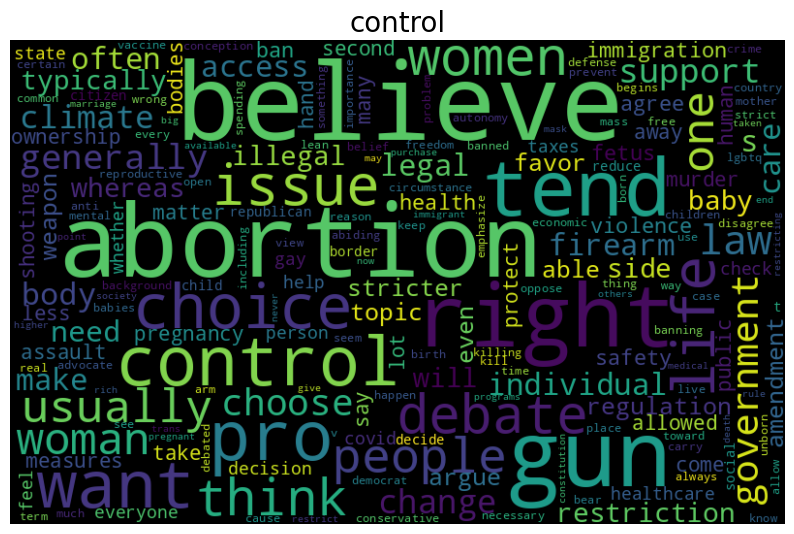

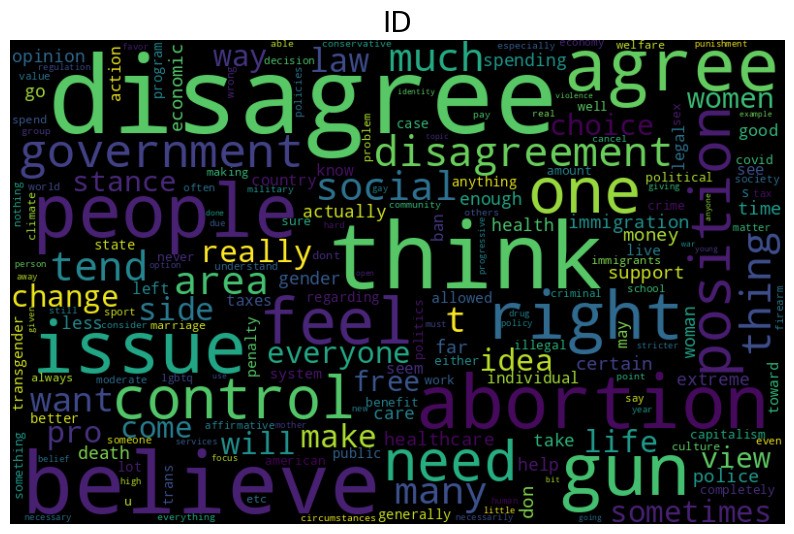

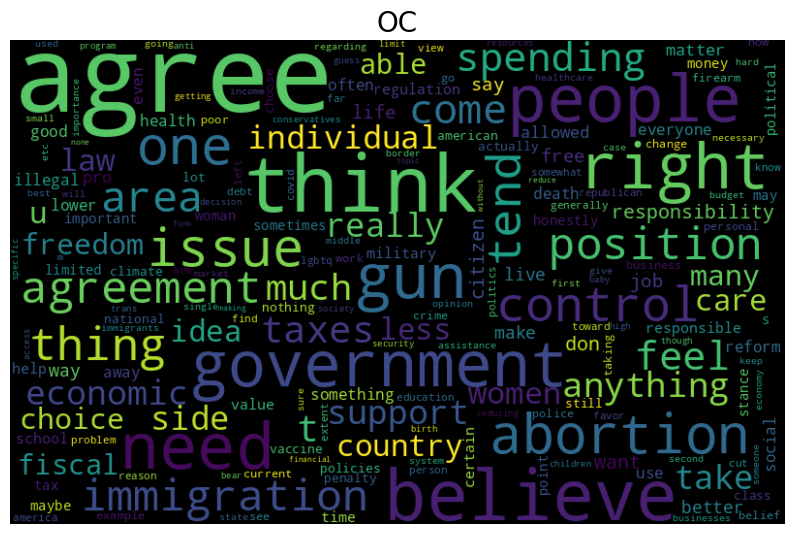

In [50]:
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer

def symbol_remover(word):
    '''
    symbol_remover replaces symbols with spaces
    '''
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for symbol in symbols:
        word = np.char.replace(word, symbol, ' ')
        word = np.char.replace(word, "'", "")
    return(str(word))

# Generate a word cloud for each topic
def generate_wordcloud(df, label, excluded_words_list=None, lemmatizer=None):

  # Convert the responses to a single string
  all_responses = ' '.join(df['response'].values)
  # Select only words_in_pos
  part_of_speech = "ALL" # @param ["ALL", "NN", "NNS", "JJ", "VB"] {allow-input: true}

  if part_of_speech != "ALL":
    words_in_pos = [lemmatizer.lemmatize(word.lower().strip()) for word, tag in TextBlob(all_responses).pos_tags if tag == part_of_speech \
                    and lemmatizer.lemmatize(symbol_remover(word).lower().strip()) not in excluded_words_list]
  else:
    words_in_pos = [word.lower().strip() for word in all_responses.split() if lemmatizer.lemmatize(symbol_remover(word).lower().strip()) not in excluded_words_list]
  all_responses_cleaned = ' '.join(words_in_pos)
  # Create the word cloud
  wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110, collocations=False, stopwords=None).generate(all_responses_cleaned)
  # Display the word cloud
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(f'{label}', fontsize=20)
  plt.show()

exclude_words = "liberal, liberals, conservative, conservatives" # @param {type:"string"}
lemmatizer = WordNetLemmatizer()
excluded_words_list = exclude_words.split(', ')
print(f'Excluded Words')
for excluded_word in excluded_words_list:
  print(f'  {excluded_word}')

for group in df[column_of_interest].unique():
  df_group = df[df[column_of_interest] == group]
  generate_wordcloud(df_group, group, excluded_words_list, lemmatizer)

In [ ]:
def word_count_search(df):
    '''
    word_counter takes in user-inputted word
    and compares all the usage of that word
    across all members of the chat
    '''
    wordSelect = input('What word are you looking to compare?').lower()
    wordUser = defaultdict(list)
    # for significance test
    for m_index, message in enumerate(df['response']):
        message_cleaned = message.lower()
        sender = str(df[column_of_interest].iloc[m_index])
        if wordSelect in message_cleaned:
            wordUser[sender].append(1)
        else:
            wordUser[sender].append(0)
    print(f'Word: {wordSelect}')
    frequencies = []
    groups = wordUser.keys()
    values_list = wordUser.values()
    for name in wordUser.keys():
        df_len = len(df[df[column_of_interest] == name])
        freq = round(np.mean(wordUser[name]), 4)
        print(f'  Frequency used by {name}: {freq} ({np.sum(wordUser[name])})')


    group_combinations = list(combinations(groups, 2))
    values_combinations = list(combinations(values_list, 2))
    ks_test_group(group_combinations, values_combinations)

word_count_search(df)

What word are you looking to compare?abortion
Word: abortion
  Frequency used by control: 0.4482 (281)
  Frequency used by ID: 0.1076 (68)
  Frequency used by OC: 0.0784 (49)
  control vs ID: ks_stat: 0.34, p_val: 7.35E-33
  control vs OC: ks_stat: 0.37, p_val: 1.22E-38
  ID vs OC: ks_stat: 0.03, p_val: 9.41E-01


In [ ]:
# import stopwords
from nltk.corpus import stopwords

def token_cleaner(df):
    '''
    token_cleaner removes unnecessary words (e.g. and, the, what)
    for future analyses. I could have done it earlier, but I thought
    maybe, for whatever reason, if anyone would be interested in
    how often either of use any of these words, it would be you.
    '''
    allWords = defaultdict(list)
    stopWords = stopwords.words('english')
    m_index = 0
    for m_index, message in enumerate(df['response']):
        sender = df[column_of_interest].iloc[m_index]
        message_cleaned = message.lower()
        for word in message_cleaned.split(' '):
            if word not in stopWords:
                word = symbol_remover(word)
                if len(word) < 1:
                    continue
                allWords[sender].append(word)
        m_index += 1
    return(allWords)

# allWords is not a dictionary with presumably only meaningful words
allWords = token_cleaner(df)

## WIP

Streaming output truncated to the last 5000 lines.
ID lgbtq 0.0008793969849246232
ID use 0.0007537688442211055
ID using 0.0007537688442211055
ID identity 0.0007537688442211055
ID letting 0.0007537688442211055
ID individuals 0.0007537688442211055
ID compete 0.0007537688442211055
ID long 0.0007537688442211055
ID sort 0.0007537688442211055
ID military 0.0007537688442211055
ID mental 0.0007537688442211055
ID progressive 0.0007537688442211055
ID look 0.0007537688442211055
ID live 0.0007537688442211055
ID restrictions 0.0007537688442211055
ID importance 0.0007537688442211055
ID police  0.0007537688442211055
ID try 0.0007537688442211055
ID society 0.0007537688442211055
ID sports 0.0007537688442211055
ID capitalism 0.0007537688442211055
ID laws  0.0007537688442211055
ID areas 0.0007537688442211055
ID covid 0.0007537688442211055
ID toward 0.0007537688442211055
ID moderate 0.0007537688442211055
ID rather 0.0007537688442211055
ID community 0.0007537688442211055
ID justice 0.0007537688442211055
ID

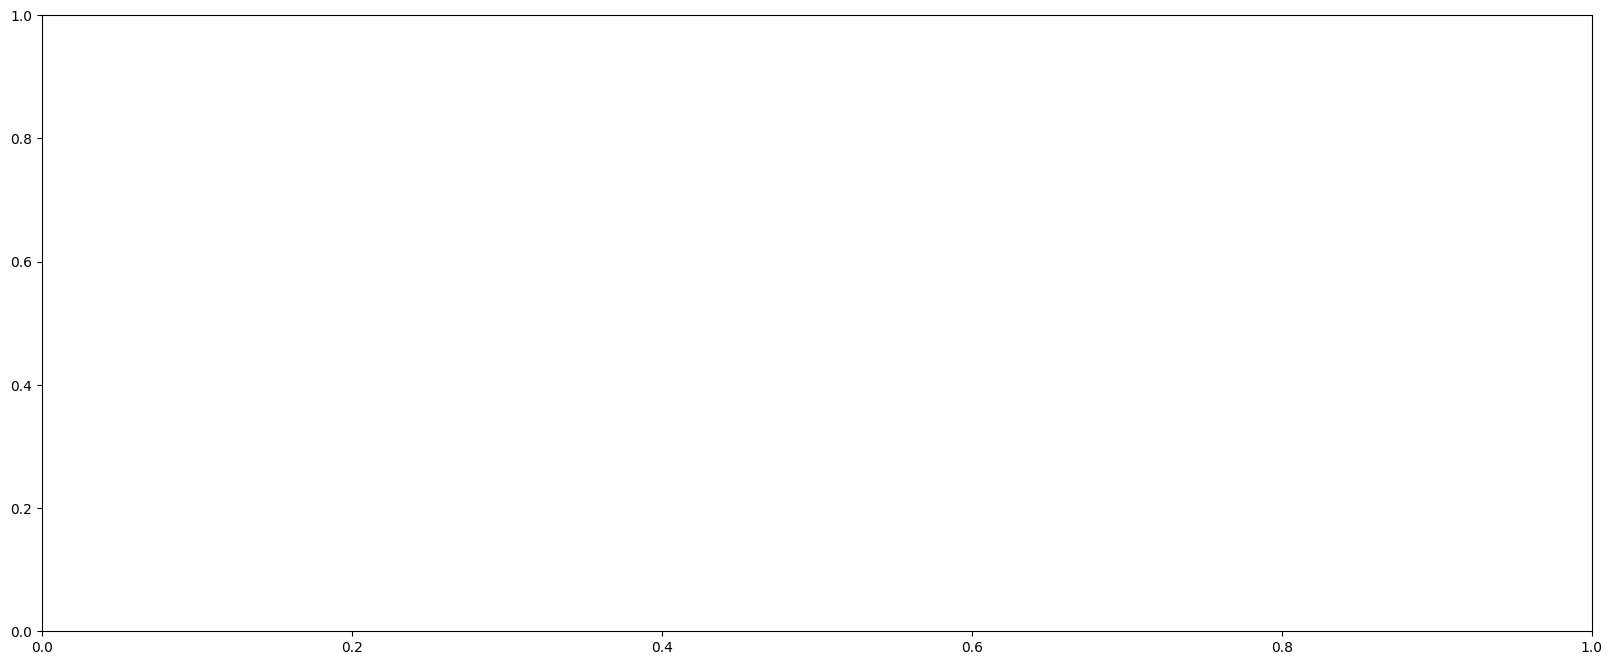

In [ ]:
from nltk.probability import FreqDist
from collections import Counter, OrderedDict

def words_plotter(NUM_OF_WORDS, word_count_groups):
    '''
    words_plotter plots the usage of top words, by user
    '''
    x = np.arange(NUM_OF_WORDS)
    f, ax = plt.subplots(1, figsize=(20,8))
    width = 0.3

    groups = word_count_groups.keys()
    instances_of_words = []
    for group in groups:
      top_n_words = word_count_groups[group].keys()
      for word in top_n_words:
        instances_of_words.append(word_count_groups[group][word])
        print(group, word, word_count_groups[group][word])
    # plt.bar(x, word_count_group, width=width, ec='black')

    # ax.set_xticks(x+width/2)
    # ax.set_xticklabels(words, rotation=45)
    # plt.title('Ordered by ' + user + '\'s Top Words')
    # plt.xlabel('Word')
    # plt.ylabel('Frequency of Word')
    # plt.legend()
    # plt.show()

def top_words_by_group(num_top_words):
    '''
    top_words_by_group analyzes the top words used by each user
    and compares the volume differences by each
    '''
    word_count_groups = defaultdict(lambda: defaultdict(float))
    for group in df[column_of_interest].unique():
      fdist_group = Counter(dict(FreqDist(allWords[group])))

      wordsOrdered_hash_group = OrderedDict(sorted(fdist_group.items(),
                                      reverse=True, key=lambda t: t[1]))

      # total number of words in each corpus to normalize
      total_words_group = sum(wordsOrdered_hash_group.values())
      for word in wordsOrdered_hash_group.keys():
        word_count_groups[group][word] = wordsOrdered_hash_group[word]/total_words_group

    words_plotter(NUM_OF_WORDS, word_count_groups)

NUM_OF_WORDS = 30
top_words_by_group(NUM_OF_WORDS)